# TP- ICA, PCA, NMF

## Introduction

In [92]:
import wave
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.decomposition import FastICA, PCA
from time import time
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.datasets import fetch_olivetti_faces
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

### Question 1: Étudier le script ica_audio.py et l'utiliser pour générer le mélange stéréo. Prendre le temps d'écouter les différents signaux.

In [93]:
# -- Read audio data ----------------------------------------------------------


def wavread(filename):
    """Read .wav file"""
    wf = wave.open(filename)
    s = np.fromstring(wf.readframes(wf.getnframes()), dtype=np.int16)
    wf.close()
    return s


def wavwrite(filename, s, nchannels=1):
    """Write .wav file"""
    wf = wave.open(filename, 'wb')
    wf.setnchannels(nchannels)
    wf.setsampwidth(2)
    wf.setframerate(32000)
    s = s / np.max(np.abs(s)) * 2 ** 14  # normalise arbitrarily
    wf.writeframes(s.astype(np.int16).tostring())
    wf.close()

In [94]:
s1 = wavread('./snd/es02.wav')
s2 = wavread('./snd/si01.wav')

In [95]:
# -- Create stereo mix --------------------------------------------------------

nsmp = min(len(s1), len(s2))
s1 = s1[:nsmp]
s2 = s2[:nsmp]
S = np.c_[s1, s2]
# Mixing matrix
A = np.array([[0.6, 0.5],
              [0.4, 0.5]])
# Do the mix
X = S.dot(A)
# Write mix file
x = np.zeros(2 * nsmp)
x[::2] = X[:, 0]
x[1::2] = X[:, 1]
wavwrite('./snd/mix.wav', x, nchannels=2)

### Question 2. Utiliser l'ICA pour extraire les sources originales à partir du mélange.

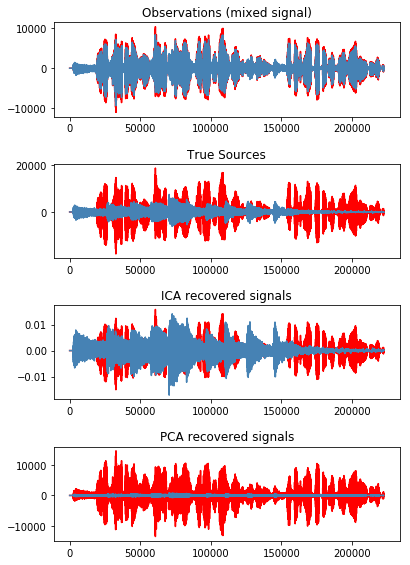

In [96]:
# -- ICA source separation ----------------------------------------------------

# Compute ICA
ica = FastICA(n_components=2)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix


# For comparison, compute PCA
pca = PCA(n_components=2)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components


# Visualise sources
# #############################################################################
# Plot results

plt.figure()

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.2, 0.2, 1, 2, 0.2, 0.5)
plt.show()

### Question 3. Créer les fichiers audio pour chaque source extraite et les écouter.

In [7]:
# Write audio sources
wavwrite('./snd/s1_byica.wav', S_[:, 0], nchannels=1)
wavwrite('./snd/s2_byica.wav', S_[:, 1], nchannels=1)

#### La stéréo mélangé est bien séparé en deux partie, les radios décomposés sont pareils avec les sources originales.

## Extraction de caractéristiques de visages

### Question 1: Analyser le type de décomposition obtenu par NMF en comparaison avec celui obtenu par PCA.

In [100]:
# -- Prepare data and define utility functions --------------------------------

n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 400 faces


In [102]:
def plot_gallery(title, images):
    """Plot images as gallery"""
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp < 0)
        if len(dmy[0]) > 0:
            yz, xz = dmy
        comp[comp < 0] = 0

        plt.imshow(comp, cmap=plt.cm.gray, vmax=vmax, vmin=vmin)

        if len(dmy[0]) > 0:
            plt.plot(xz, yz, 'r,', hold=True)
            print(len(dmy[0]), "negative-valued pixels")

        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

2061 negative-valued pixels
2773 negative-valued pixels
2630 negative-valued pixels
1422 negative-valued pixels
1242 negative-valued pixels
1004 negative-valued pixels
2049 negative-valued pixels
1580 negative-valued pixels
1387 negative-valued pixels
3819 negative-valued pixels
Extracting the top 10 Eigenfaces - PCA...
done in 0.090s
3998 negative-valued pixels
2078 negative-valued pixels
1967 negative-valued pixels
1862 negative-valued pixels
2261 negative-valued pixels
1924 negative-valued pixels
1951 negative-valued pixels
1883 negative-valued pixels
2221 negative-valued pixels
2127 negative-valued pixels
Extracting the top 10 Non-negative components - NMF...
done in 5.000s


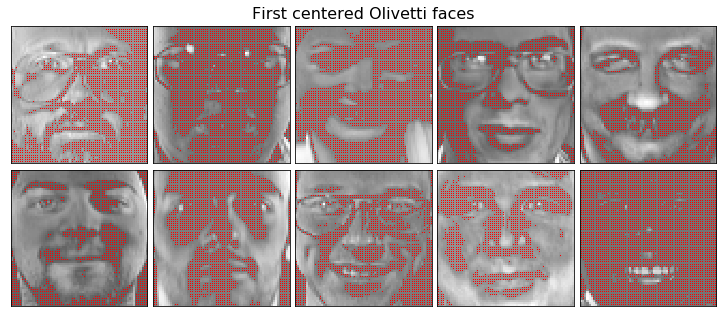

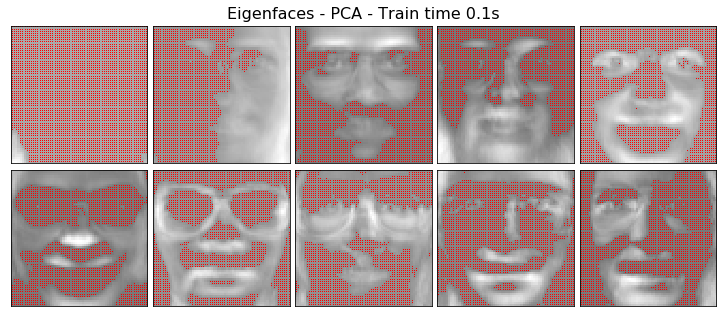

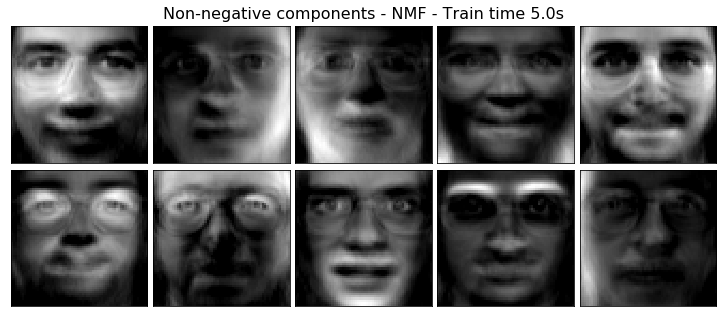

In [103]:
# Plot a sample of the input data
plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# -- Decomposition methods ----------------------------------------------------

# List of the different estimators and whether to center the data

estimators = [
    ('pca', 'Eigenfaces - PCA',
     decomposition.PCA(n_components=n_components, whiten=True),
     True),

    ('nmf', 'Non-negative components - NMF',
     decomposition.NMF(n_components=n_components,
                       init=None, tol=1e-6, max_iter=1000),
     False)
]

# -- Transform and classify ---------------------------------------------------

labels = dataset.target
X = faces
X_ = faces_centered

for shortname, name, estimator, center in estimators:
    if shortname == 'nmf':
        print("Extracting the top %d %s..." % (n_components, name))
        t0 = time()

        data = X
        if center:
            data = X_

        data = estimator.fit_transform(data)

        train_time = (time() - t0)
        print("done in %0.3fs" % train_time)

        components_ = estimator.components_

        plot_gallery('%s - Train time %.1fs' % (name, train_time),
                     components_[:n_components])

    elif shortname == 'pca':

        print("Extracting the top %d %s..." % (n_components, name))
        t0 = time()

        data = X
        if center:
            data = X_

        data = estimator.fit_transform(data)

        train_time = (time() - t0)
        print("done in %0.3fs" % train_time)

        components_ = estimator.components_

        plot_gallery('%s - Train time %.1fs' % (name, train_time),
                     components_[:n_components])
    else:
        continue

plt.show()

#### Selon l'affichage par PCA et par NMF, iles images décomposés par NMF sont plus visualisé par rapport de ceux de PCA. C'est parce que la décomposition PCA renvoie des valeurs potentiellement négatives, et ces négatives sont affichés en rouge dans les image, donc il est plus difficile à voir les features extraits. Par contre, au point de vue de coût de calcul, PCA est beaucoup plus performant, soit 50 fois plus rapide pour NMF dans notre cas d'étude.

### Question 2. Modifier le script pour réaliser une évaluation des performances d'un système de reconnaissance automatique de visages utilisant les caractéristiques extraites par PCA, comparées à celles obtenues par un système exploitant les caractéristiques extraites par NMF. On pourra utiliser la LDA pour la classification. On effectuera l'évaluation par validation croisée. On observera l'évolution des scores en faisant varier le nombre de composantes utilisé dans les décompositions.

In [104]:
components_to_decom = range(2, 30)
PCA_score = []
NMF_score = []

for n_components in components_to_decom:
    # print(n_components)
    estimators = [
        ('pca', 'Eigenfaces - PCA',
         decomposition.PCA(n_components=n_components, whiten=True),
         True),

        ('nmf', 'Non-negative components - NMF',
         decomposition.NMF(n_components=n_components,
                           init=None, tol=1e-6, max_iter=1000),
         False)]
    for shortname, name, estimator, center in estimators:
        # print("For estimator %s..." % name)
        data = X
        if center:
            data = X_

        X_trans = estimator.fit_transform(data)
        clf = LDA()
        scores = cross_val_score(clf, X_trans, labels, cv=6)
        score = scores.mean()

        if shortname == "pca":
            PCA_score.append(score)
        else:
            NMF_score.append(score)

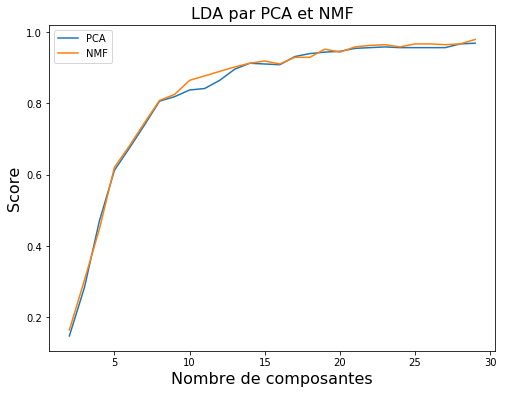

In [105]:
plt.figure(figsize=(8, 6))
plt.plot(components_to_decom, PCA_score, components_to_decom, NMF_score)
plt.legend(['PCA', 'NMF'])
plt.title("LDA par PCA et NMF", fontsize=16)
plt.xlabel('Nombre de composantes', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.show()

#### Il est trouvé que pour la reconnaissance de visages, au moins dans ce ças étudié, les performances de PCA et de NMF sont bien proches. Globalement les score de classification sont plus élevées avec l'augmentation de nombre de composantes extraits, puis le seuil de score est autour de nombre de composantes 20. Si strictement, la NMF montre légèrement mieux que PCA, par contre le coût de calcul est aussi important à compter. Pour conclure, les deux méthode de décomposition sont tout efficaces, mais l'utilisation entre eux dépend la problématique actuelle en équilibrant ces caractéristiques respectives.

### Question 3. Utiliser la NMF pour l'extration de thèmes à partir d'un corpus de textes

In [106]:
from time import time
from sklearn import datasets
from sklearn import decomposition
from sklearn.feature_extraction import text

n_samples = 1000
n_features = 900
n_topics = 10
n_top_words = 20

# Load the 20 newsgroups dataset and vectorize it using the most common word
# frequency with TF-IDF weighting (without top 5% stop words)

t0 = time()
print("Loading dataset and extracting TF-IDF features...")
dataset = datasets.fetch_20newsgroups(data_home='c:/tmp/', shuffle=True,
                                      random_state=1)
vectorizer = text.CountVectorizer(max_df=0.95, max_features=n_features)
counts = vectorizer.fit_transform(dataset.data[:n_samples])
tfidf = text.TfidfTransformer().fit_transform(counts)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model on with n_samples=%d and n_features=%d..." %
      (n_samples, n_features))
nmf = decomposition.NMF(n_components=n_topics).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

# Inverse the vectorizer vocabulary to be able
feature_names = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Loading dataset and extracting TF-IDF features...
done in 0.701s.
Fitting the NMF model on with n_samples=1000 and n_features=900...
done in 1.046s.
Topic #0:
the of in and on was to as at is which by were one with for they that when two

Topic #1:
chip clipper key the to encryption keys government be will this public as is or of can that it use

Topic #2:
is that of to not are and the we in as be people they it this there or god their

Topic #3:
edu university host posting cs nntp of re in article cc writes reply distribution washington cwru state mit for anyone

Topic #4:
com hp in article writes inc netcom corp stratus re sun posting nntp host dec ca jim org that corporation

Topic #5:
he his was to and him that who the had my in it but year this ca me team be

Topic #6:
uk ac co of university ___ dc posting host nntp thanks __ sorry college it please where return sun writes

Topic #7:
you to it your my have can if do and that car get like with don on what just so

Topic #8:
nasa go

#### La LDA est appliqués pour la classification, l'évaluation est effectuée par validation croisée.

In [107]:
X_nmf = nmf.transform(tfidf)
clf = LDA()
scores = cross_val_score(clf, X_nmf, dataset.target[:n_samples], cv=6)
score = scores.mean()
print("Classification score by NMF:", score)

Classification score by NMF: 0.280112573553


#### La classification actuelles n'est pas bien efficace, on va donc essayer de réduire la dimention de target pour mieux classifier.

In [108]:
target_redu = np.array([elt.split('.')[0] for elt in dataset.target_names])
label_redu = target_redu[dataset.target]
scores_by_redu = cross_val_score(clf, X_nmf, label_redu[:n_samples], cv=6)
score_by_redu = scores_by_redu.mean()
print("Classification score by NMF with the reduce of target dimention :", score_by_redu)

Classification score by NMF with the reduce of target dimention : 0.549760302344


#### Avec le réduction de dimension de target, la classification est améliorée à peu près une fois.

#### Nous avons remarqué que le Topic 1 est inutile, ils sont plutôt stop words. Ensuite nous allons filter ces stop words avant l'analyse.

In [109]:
t0 = time()
vectorizer_refined = text.CountVectorizer(
    max_df=0.95, max_features=n_features, stop_words='english')
counts_refined = vectorizer_refined.fit_transform(dataset.data[:n_samples])
tfidf_refined = text.TfidfTransformer().fit_transform(counts_refined)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model on with n_samples=%d and n_features=%d..." %
      (n_samples, n_features))
nmf_refined = decomposition.NMF(n_components=n_topics).fit(tfidf_refined)
print("done in %0.3fs." % (time() - t0))

# Inverse the vectorizer vocabulary to be able
feature_names = vectorizer_refined.get_feature_names()
for topic_idx, topic in enumerate(nmf_refined.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

done in 0.333s.
Fitting the NMF model on with n_samples=1000 and n_features=900...
done in 0.459s.
Topic #0:
god bible jesus christian people life christians christ religion faith mary believe christianity church belief children say good think evil

Topic #1:
edu university cs posting host article nntp writes cc reply distribution pitt state uiuc michael washington john cwru thanks david

Topic #2:
com hp article writes netcom sun corp stratus posting nntp host news jim uunet distribution reply support att corporation systems

Topic #3:
windows drive help card problem software file monitor dos driver use drivers using pc thanks color window version computer video

Topic #4:
clipper chip key encryption government keys public secure enforcement use people law secret house standard algorithm phone pat na security

Topic #5:
nasa gov space center jpl research shuttle program laboratory distribution brian earth data world sci long posting nntp host article

Topic #6:
uk ac university thanks

#### Sans les stop words, les topic deviennent plus compréhensibles. Puis on applique la LCA pour évaluer la performance de décomposition.

In [110]:
X_nmf_refined = nmf_refined.transform(tfidf_refined)
clf = LDA()
scores_refined = cross_val_score(clf, X_nmf_refined, dataset.target[:n_samples], cv = 6)
score_refined = scores_refined.mean()
print("Classification score by NMF without stop words", score_refined)

Classification score by NMF without stop words 0.319197122654


In [112]:
target_redu = np.array([elt.split('.')[0] for elt in dataset.target_names])
label_redu = target_redu[dataset.target]
scores_refined_by_redu = cross_val_score(clf, X_nmf_refined, label_redu[:n_samples], cv=6)
score_refined_by_redu = scores_refined_by_redu.mean()
print("Classification score by NMF without stop words and with the reduce of target dimention :", score_refined_by_redu)

Classification score by NMF without stop words and with the reduce of target dimention : 0.599129383989


#### Avec l'élimination des stop words, l'extration de thèmes devient plus précis.

#### Ensuite les topics extraits sont visualisés au-dessous:

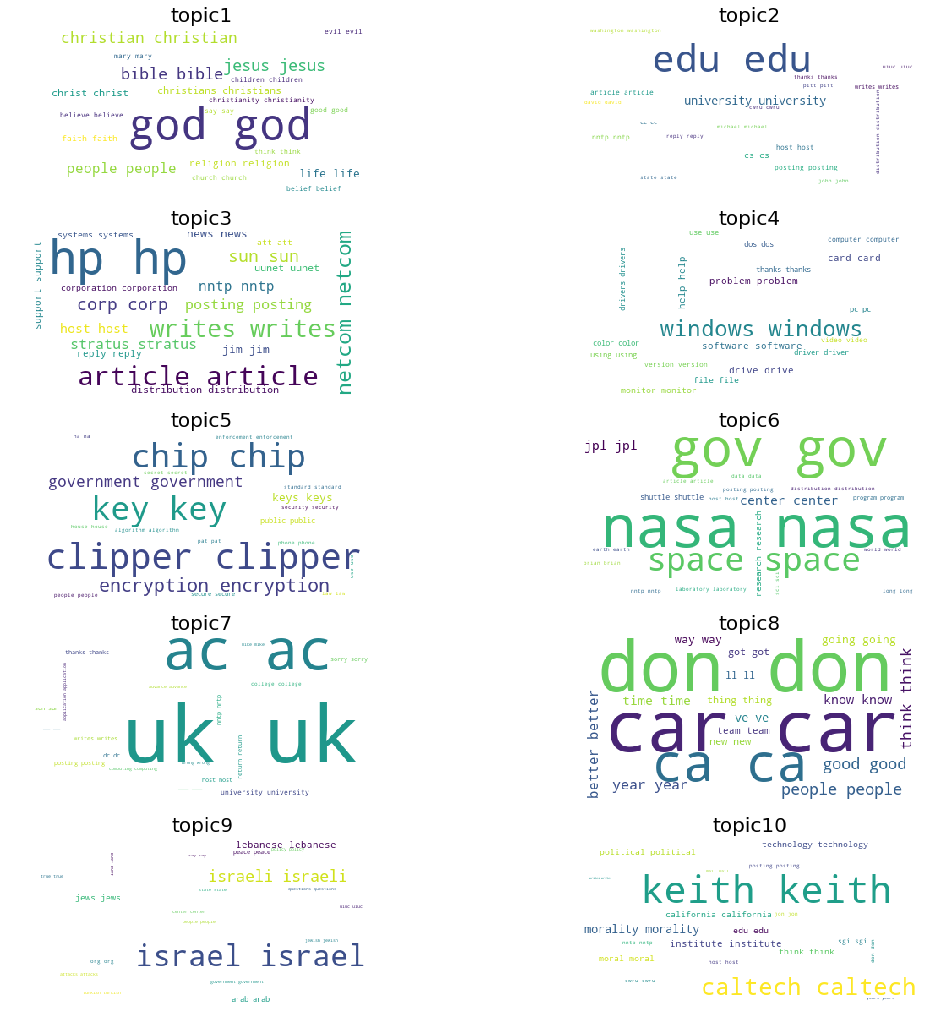

In [113]:
from wordcloud import WordCloud, STOPWORDS

doc = dict()
for topic_idx, topic in enumerate(nmf_refined.components_):
    doc[topic_idx]=' '.join([(feature_names[i]+ ' ') * int(round(topic[i]*200))
                   for i in topic.argsort()[:-n_top_words - 1:-1]])
    
plt.figure(figsize=(18, 18));
for i in range(10):
    wordcloud = WordCloud(relative_scaling = 1.0,background_color = "white").generate(doc[i])
    plt.subplot(5, 2, i+1)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("topic"+str(i+1),fontsize = 20)
plt.show()